### Project  Movie Prophet
#### A project to create a predictive model to forecast a movie's performance on the Box Office
#### Team Members - Nelson Dsouza, Maria George, Saurabh Seth

### Common

In [15]:
# Load libraries and instatiate DB connection

%matplotlib inline
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='mprophet',
                             db='movies')

In [16]:
# Pull table from database

cur = connection.cursor()

cur.execute("select * FROM bom")
bom_sql = []
for row in cur: bom_sql.append(list(row))

cur.close()
connection.close()

In [17]:
# Store table information in DataFrame

bom_columns =         ['bom_title', 'bom_link', 'bom_key', 'bom_date', 'bom_year', 'bom_name', 'bom_budget',
                       'bom_domestic_gross', 'bom_lifetime_gross', 'bom_release_date', 'bom_runtime', 'bom_distributor',
                       'bom_genre', 'bom_rating', 'bom_awards', 'bom_actor', 'bom_assoc_producer', 'bom_cinematographer',
                       'bom_composer', 'bom_director', 'bom_exec_producer', 'bom_line_producer', 'bom_players', 'bom_producer',
                       'bom_writer', 'bom_close_date', 'bom_domestic_summary', 'bom_in_release', 'bom_limited_opening_weekend',
                       'bom_opening_weekend', 'bom_wide_opening_weekend', 'bom_widest_release', 'bom_domestic_revenue',
                       'bom_foreign_revenue', 'bom_worldwide_revenue', 'bom_total_lifetime_gross']

bom = pd.DataFrame(bom_sql, columns=bom_columns)
#bom.to_csv('bom.csv')
print('Total movies from Box Office Mojo:', len(bom))
bom.head(1)

Total movies from Box Office Mojo: 16826


,bom_title,bom_link,bom_key,bom_date,bom_year,bom_name,bom_budget,bom_domestic_gross,bom_lifetime_gross,bom_release_date,bom_runtime,bom_distributor,bom_genre,bom_rating,bom_awards,bom_actor,bom_assoc_producer,bom_cinematographer,bom_composer,bom_director,bom_exec_producer,bom_line_producer,bom_players,bom_producer,bom_writer,bom_close_date,bom_domestic_summary,bom_in_release,bom_limited_opening_weekend,bom_opening_weekend,bom_wide_opening_weekend,bom_widest_release,bom_domestic_revenue,bom_foreign_revenue,bom_worldwide_revenue,bom_total_lifetime_gross
0,#horror,http://www.boxofficemojo.com/movies/?id=horrorifc.htm,b0,20-Nov-15,2015\r,#Horror,N/A,,,20-Nov-15,1 hrs. 30 min.,IFC,Horror,Unknown,No Academy Awards Information\r,"""['Balthazar Getty', 'Timothy Hutton', 'Natasha Lyonne', 'Taryn Manning', 'Chloe Sevigny']""",,,,,,,,,\r,,No Domestic Summary Information,,,,,\r,,,,No Total Lifetime Gross Information\r


### Nelson

In [4]:
# Cleaning actor names and storing in list

bom_ftr = bom.copy()

print('Movies with no player information:', len(bom_ftr[bom_ftr['bom_players'] == 'No Player Information']))

# Clean the actor column
bom_ftr['actor_clean'] = bom_ftr['bom_actor'].str.replace('[','')
bom_ftr['actor_clean'] = bom_ftr['actor_clean'].str.replace(']','')
bom_ftr['actor_clean'] = bom_ftr['actor_clean'].str.replace('"','')
bom_ftr['actor_clean'] = bom_ftr['actor_clean'].str.replace("'",'')
bom_ftr['actor_clean'] = bom_ftr['actor_clean'].str.replace(", ",',')
bom_ftr['actor_clean'] = bom_ftr['actor_clean'].str.replace("*",',')

bom_ftr['actor_clean'] = bom_ftr['actor_clean'].apply(lambda x: x.split(','))

Movies with no player information: 6419


In [18]:
# Calclulate the revenue ratio for each movie which has data for budget and domestic total gross 

print('Movies with no budget information:', len(bom_ftr[bom_ftr['bom_budget'] == 'N/A']))
print('Movies with no gross total information:', len(bom_ftr[bom_ftr['bom_domestic_gross'] == '']))

bom_ftr_rev = bom_ftr[(bom_ftr['bom_budget'] != 'N/A') & (bom_ftr['bom_domestic_gross'] != '')].copy()
bom_ftr_rev.reset_index(inplace=True)
bom_ftr_rev['bom_budget'] = bom_ftr_rev['bom_budget'].str.replace('$','')
bom_ftr_rev['bom_budget'] = bom_ftr_rev['bom_budget'].str.replace('"','')
bom_ftr_rev['bom_budget'] = bom_ftr_rev['bom_budget'].str.replace(',','')

bom_ftr_rev.loc[bom_ftr_rev.bom_budget.str.contains('million'),'bom_budget'] = bom_ftr_rev.loc[
    bom_ftr_rev.bom_budget.str.contains('million'), 'bom_budget'].apply(lambda x: float(x.replace('million', ''))*1000000)

bom_ftr_rev['bom_domestic_gross'] = bom_ftr_rev['bom_domestic_gross'].astype(float)
bom_ftr_rev['bom_budget'] = bom_ftr_rev['bom_budget'].astype(float)
bom_ftr_rev['bom_revenue'] = (bom_ftr_rev['bom_domestic_gross'] - bom_ftr_rev['bom_budget']) / bom_ftr_rev['bom_budget']

print('\nMovies with revenue information:', len(bom_ftr_rev))
bom_ftr_rev.head(1)

Movies with no budget information: 13712
Movies with no gross total information: 1973

Movies with revenue information: 3066


,index,bom_title,bom_link,bom_key,bom_date,bom_year,bom_name,bom_budget,bom_domestic_gross,bom_lifetime_gross,bom_release_date,bom_runtime,bom_distributor,bom_genre,bom_rating,bom_awards,bom_actor,bom_assoc_producer,bom_cinematographer,bom_composer,bom_director,bom_exec_producer,bom_line_producer,bom_players,bom_producer,bom_writer,bom_close_date,bom_domestic_summary,bom_in_release,bom_limited_opening_weekend,bom_opening_weekend,bom_wide_opening_weekend,bom_widest_release,bom_domestic_revenue,bom_foreign_revenue,bom_worldwide_revenue,bom_total_lifetime_gross,actor_clean,bom_revenue,bom_actor_score
0,10,(500) days of summer,http://www.boxofficemojo.com/movies/?id=500daysofsummer.htm,b10,17-Jul-09,2009\r,(500) Days of Summer,7500000,32391374,,17-Jul-09,1 hrs. 35 min.,Fox Searchlight,Romance,PG-13,No Academy Awards Information\r,"""['Zooey Deschanel', 'Geoffrey Arend', 'Chloe Moretz', 'Clark Gregg', 'Minka Kelly*']""",,,"""['Mychael Danna', 'Rob Simonsen']""",['Marc Webb'],,,,"""['Mason Novick', 'Mark S. Waters']""","""['Scott Neustadter', 'Michael H. Weber']""\r",""" November 22, 2009""",,133 days / 19 weeks,"""<b> $834,501</b>""",,"""$3,739,702 """,""" 1,048 theaters""\r","""$32,391,374 ""","""$28,331,360 ""","""$60,722,734 """,\r,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly, ]",3.31885,0


In [19]:
# Getting unique actors

actor_unq = list(bom_ftr['actor_clean'])
actor_unq = list(set(sum(actor_unq, [])))
actor_unq = [e for e in actor_unq if e not in ('', ' ')]
actor_unq = dict((ky,0) for ky in actor_unq)
print('Unique actors in bom: ', len(actor_unq))

# For each actor, assigning score based on revenue of their movie

mov_actors = list(bom_ftr_rev['actor_clean'])
mov_actors = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_actors]

ind = 0
for actors in mov_actors:
    for actor in actors:
        actor_unq[actor] += float(bom_ftr_rev.loc[ind, ['bom_revenue']])
    ind+=1

Unique actors in bom:  5054


In [13]:
actor_unq['Juliette Binoche']

-1.316072090827922

In [29]:
# Pull the actor feature into dataframe and calculate stats

f_actor = pd.Series(actor_unq, name='score').to_frame()
f_actor = f_actor.sort_values(by='score', ascending=False)
f_actor.reset_index(inplace=True)
f_actor.columns=['Actors', 'score']
print(f_actor.head(5))
f_actor.describe().transpose()

             Actors       score
0     Alex Kendrick  182.957054
1  Jamie Lee Curtis  152.799540
2       Kevin Smith  120.342816
3       Jason Mewes  118.917896
4         Jon Heder  111.434016


,count,mean,std,min,25%,50%,75%,max
score,5054,2.284961,7.838677,-6.247023,0,0,0.763927,182.957054


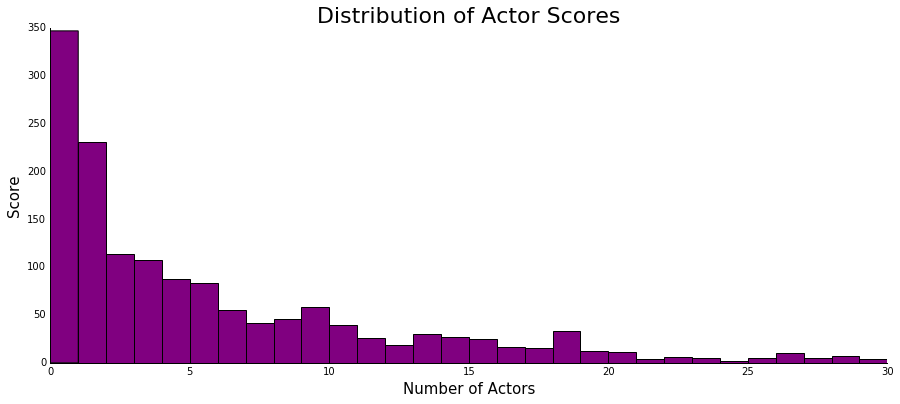

In [11]:
# Analyzing distribution

plt.figure(1, figsize = (15,6))
plt.hist(list(f_actor[f_actor['score'] != 0]['score']), range=[0,30], bins=(30), facecolor='purple')
plt.title("Distribution of Actor Scores", fontsize = 22)
plt.ylabel("Score", fontsize = 15)
plt.xlabel("Number of Actors", fontsize=15)

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')

plt.savefig('Actor_Distribution.png')

In [28]:
# For each movie, assigning actor score

bom_ftr_rev["bom_actor_score"] = 0.0
ind = 0
for actors in mov_actors:
    agg_actor_score = 0
    for actor in actors:
        agg_actor_score += actor_unq[actor]
    bom_ftr_rev.loc[ind, ['bom_actor_score']] = agg_actor_score
    ind+=1
    
bom_ftr_rev.head(1)

,index,bom_title,bom_link,bom_key,bom_date,bom_year,bom_name,bom_budget,bom_domestic_gross,bom_lifetime_gross,bom_release_date,bom_runtime,bom_distributor,bom_genre,bom_rating,bom_awards,bom_actor,bom_assoc_producer,bom_cinematographer,bom_composer,bom_director,bom_exec_producer,bom_line_producer,bom_players,bom_producer,bom_writer,bom_close_date,bom_domestic_summary,bom_in_release,bom_limited_opening_weekend,bom_opening_weekend,bom_wide_opening_weekend,bom_widest_release,bom_domestic_revenue,bom_foreign_revenue,bom_worldwide_revenue,bom_total_lifetime_gross,actor_clean,bom_revenue,bom_actor_score
0,10,(500) days of summer,http://www.boxofficemojo.com/movies/?id=500daysofsummer.htm,b10,17-Jul-09,2009\r,(500) Days of Summer,7500000,32391374,,17-Jul-09,1 hrs. 35 min.,Fox Searchlight,Romance,PG-13,No Academy Awards Information\r,"""['Zooey Deschanel', 'Geoffrey Arend', 'Chloe Moretz', 'Clark Gregg', 'Minka Kelly*']""",,,"""['Mychael Danna', 'Rob Simonsen']""",['Marc Webb'],,,,"""['Mason Novick', 'Mark S. Waters']""","""['Scott Neustadter', 'Michael H. Weber']""\r",""" November 22, 2009""",,133 days / 19 weeks,"""<b> $834,501</b>""",,"""$3,739,702 """,""" 1,048 theaters""\r","""$32,391,374 ""","""$28,331,360 ""","""$60,722,734 """,\r,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly, ]",3.31885,50.56333


### Maria

In [ ]:
# Filtering bom for data for which 

### Saurabh